<a href="https://colab.research.google.com/github/vasisvaran/Deep-Learning-Papers-Reading-Roadmap/blob/master/week10/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MSDS458 Research Assignment 4:
### Submitted by: Vasu (Vasisvaran) Gopal

## Import packages 

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image as img

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import os
import random
from PIL import Image
import sys
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from packaging import version

## Verify TensorFlow Version and Keras Version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.11.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.11.0


## Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Download and extract dataset from Google Drive

In [5]:
!apt install unzip
!unzip -q "/content/gdrive/MyDrive/Temp/archive.zip"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


## Loading HAR Dataset

In [6]:
# Reading the csv file into a dataframe

df = pd.read_csv('/content/Human Action Recognition/Training_set.csv')
df

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


## Exploratory Data Analysis (EDA)

In [7]:
# Checking the data types

df.dtypes

filename    object
label       object
dtype: object

In [8]:
# Checking for null values

df.isnull().sum()

filename    0
label       0
dtype: int64

In [9]:
# Checking label counts

counts = df['label'].value_counts()
counts

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64

In [10]:
# Function to display few random images

def displayRandom(n=1):
    plt.figure(figsize=(20,20))
    for i in range(n):
        rnd = random.randint(0,len(df)-1)
        img_file = '/content/Human Action Recognition/train/' + df['filename'][rnd]

        if os.path.exists(img_file):
            plt.subplot(n//2+1, 2, i + 1)
            image = img.imread(img_file)
            plt.imshow(image)
            plt.title(df['label'][rnd])

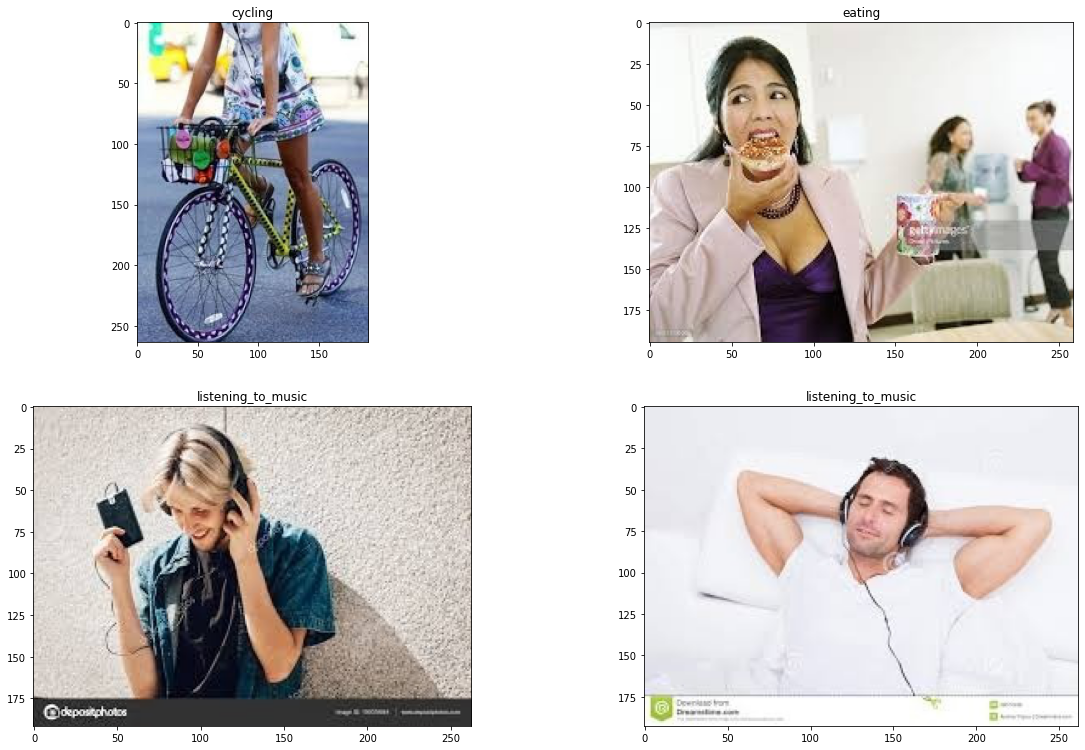

In [11]:
# Displaying 4 random images with corresponding label

displayRandom(4)

## Data Preprocessing

In [12]:
# Label encoding and seperate dependant variable

lb = LabelBinarizer()
y = lb.fit_transform(df['label'])
classes = lb.classes_
print(classes)

['calling' 'clapping' 'cycling' 'dancing' 'drinking' 'eating' 'fighting'
 'hugging' 'laughing' 'listening_to_music' 'running' 'sitting' 'sleeping'
 'texting' 'using_laptop']


In [13]:
# Take independant variable as numpy array

x = df['filename'].values

In [14]:
# Split data as 90% of training and 10% of test data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=100) 

In [15]:
# Load pixel data as a list of numpy arrays

img_data = []
size = len(x_train)

for i in tqdm(range(size)):
    image = Image.open('/content/Human Action Recognition/train/' + x_train[i])
    img_data.append(np.asarray(image.resize((160,160))))

  0%|          | 0/11340 [00:00<?, ?it/s]

## Build the CNN model


In [16]:
# Creating the model 

model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(160,160,3),
                   pooling='avg',classes=15,
                   weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(15, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


## Compile the CNN model

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________


## Train the CNN model

In [21]:
# Training the model

history = model.fit(np.asarray(img_data), y_train, validation_split=0.20, epochs=2)

Epoch 1/2
284/284 [==============================] - 5s 18ms/step - loss: 0.9151 - accuracy: 0.7035 - val_loss: 0.9453 - val_accuracy: 0.6922
Epoch 2/2
284/284 [==============================] - 4s 14ms/step - loss: 0.6586 - accuracy: 0.7844 - val_loss: 1.0212 - val_accuracy: 0.6640


In [19]:
# Saving the model weights

model.save_weights("Assignment_4_VGG16.h5")

## Plot the performance metrics

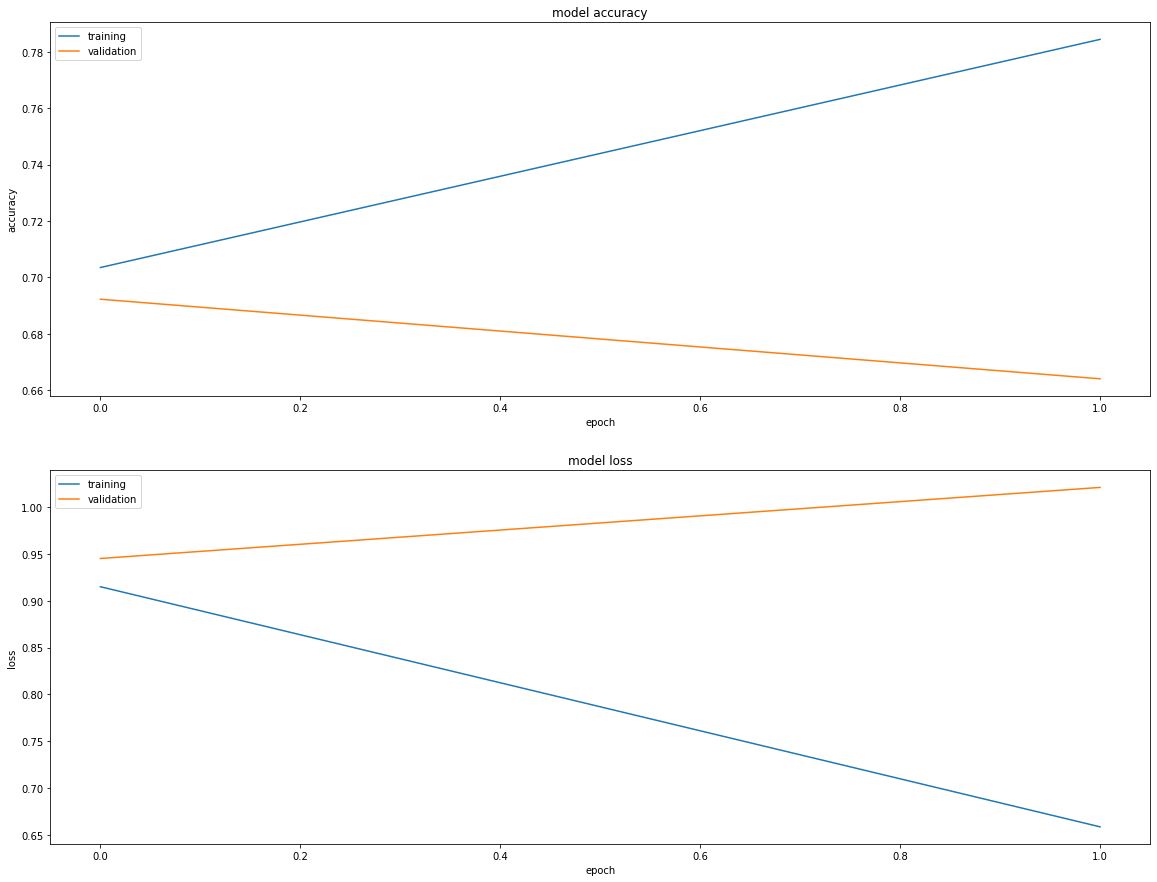

In [22]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [23]:
# Model accuracy

test_img_data = []
size = len(x_test)

for i in tqdm(range(size)):
    image = Image.open('/content/Human Action Recognition/train/' + x_test[i])
    test_img_data.append(np.asarray(image.resize((160,160))))

scores = model.evaluate(np.asarray(test_img_data), y_test)
print(f"Test Accuracy: {scores[1]}")

  0%|          | 0/1260 [00:00<?, ?it/s]

40/40 [==============================] - 1s 12ms/step - loss: 1.6483 - accuracy: 0.5405
Test Accuracy: 0.5404762029647827


In [24]:
# Function to read images as array

def read_image(fn):
    image = Image.open(fn)
    return np.asarray(image.resize((160,160)))

# Making Predictions

In [25]:
# Function to predict

def test_predict(test_image):
    result = model.predict(np.asarray([read_image(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = classes[itemindex[1][0]]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

## Create the confusion matrix

In [28]:
# Get the predicted classes
pred_classes = np.argmax(model.predict(np.asarray(test_img_data)), axis=-1)
pred_classes;


40/40 [==============================] - 1s 10ms/step


In [34]:
pred_classes.size

1260

In [29]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

InvalidArgumentError: ignored

In [31]:
import seaborn as sns

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

NameError: ignored

## Visualize the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
plot_confusion_matrix(y_test,pred_classes)

In [ ]:
test_predict('/content/Human Action Recognition/test/Image_100.jpg')

In [ ]:
test_predict('/content/Human Action Recognition/test/Image_10.jpg')

In [ ]:
test_predict('/content/Human Action Recognition/test/Image_11.jpg')

In [ ]:
test_predict('/content/Human Action Recognition/test/Image_1024.jpg')

In [ ]:
test_predict('/content/Human Action Recognition/test/Image_640.jpg')